# Problem 1: MNIST

The code for this multilayer perceptron can be found in `mnist.py`. The module `utils.py` contains helper functions to load the dataset, display progress bar, plot graphs, etc.

In [1]:
import sys
sys.path.append('../src/')
from mnist import *

---
## Building the Model

We build an MLP and choose the values of $h^1$ and $h^2$ such that the total number of parameters (including biases) falls within the range of $I = [0.5M, 1.0M]$. This can be achieved by choosing $h^1 = h^2 = 512$. Since MNIST samples are $28 \times 28 = 784$ pixels, the total number of parameters is

In [ ]:
num_params = (28*28)*512 + 512*512 + 512*10
print(num_params)

which is within range. We thus build the MLP with the parameters below.

In [2]:
# Initialize parameters
h0, h1, h2, h3 = 784, 512, 512, 10
learning_rate = 1e-2
batch_size = 64
data_filename = "../data/mnist/mnist.pkl"

We now load the tensors via Torch data loaders.

In [3]:
# Load datasets from pickled file
train_data, valid_data, test_data = unpickle_mnist(data_filename)

# Build data loaders for all three datasets
# Training set
train_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size, 
                    shuffle=True)

# Validation set
valid_loader = torch.utils.data.DataLoader(
                    valid_data,
                    batch_size=batch_size,
                    shuffle=True)

# Test set
test_loader = torch.utils.data.DataLoader(
                    test_data,
                    batch_size=batch_size,
                    shuffle=True)

---
## Initialization

Hardcoded parameters used for all three initilization schemes are:
* **Activation functions:** Rectified linear unit (ReLU)
* **Loss function:** Cross entropy
* **Optimizer:** Stochastic gradient descent (SGD) with learning rate `learning_rate`

For each initialization scheme, we compile the model and train by keeping track of the average loss. After training, we plot the result.

### Zeros

In [4]:
# Compile and train model
# Length of the training set is passed for the progress bar
# Only training data is passed for this part
model_z, loss_fn, optimizer = build_model(h0, h1, h2, h3, "zeros", learning_rate)
zero_losses = train(model_z, loss_fn, optimizer, 3, len(train_data), train_loader, [], [])[0]

Epoch 1/3
Avg loss: 2.3019 -- Train acc: 0.1135% 
Epoch 2/3
Avg loss: 2.3012 -- Train acc: 0.1135% 
Epoch 3/3
Avg loss: 2.3011 -- Train acc: 0.1135% 
Training done! Elapsed time: 0:00:18



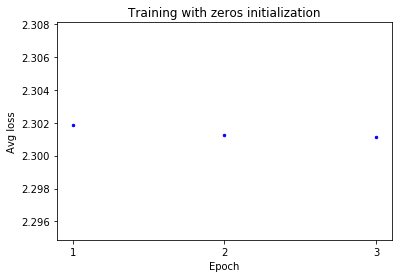

In [5]:
# Plot avg loss / epoch
%matplotlib inline
plot_per_epoch(zero_losses, "Avg loss", "Training with zeros initialization")

### Normal

In [ ]:
model_n, loss_fn, optimizer = build_model(h0, h1, h2, h3, "normal", learning_rate)
normal_losses = train(model_n, loss_fn, optimizer, 10, len(train_data), train_loader, [], [])[0]

In [ ]:
%matplotlib inline
plot_per_epoch(normal_losses, "Avg loss", "Training with Normal(0,1) initialization")

### Glorot

In [ ]:
model_g, loss_fn, optimizer = build_model(h0, h1, h2, h3, "glorot", learning_rate)
glorot_losses = train(model_g, loss_fn, optimizer, 3, len(train_data), train_loader, valid_loader, [])[0]

In [ ]:
%matplotlib inline
plot_per_epoch(glorot_losses, "Avg loss", "Training with Glorot initialization")

---
## Learning Curves

In [ ]:
model, loss_fn, optimizer = build_model(h0, h1, h2, h3, "glorot", learning_rate)
_, train_acc, valid_acc, _ = train(model, loss_fn, optimizer, 10, len(train_data), train_loader, valid_loader, [])

In [ ]:
plots_per_epoch([train_acc, valid_acc], ["Train", "Test"], "Avg Loss", "Training the model")

We now train by doubling the model capacity. This is done by doubling the number of neurons at each layer.

In [ ]:
num_params = (28*28)*2*512 + 2*512*512 + 512*10
print(num_params)

In [ ]:
model_2, loss_fn, optimizer = build_model(h0, 2*h1, 2*h2, h3, "glorot", learning_rate)
train_acc_2, _, valid_acc_2, _ = train(model_g, loss_fn, optimizer, 10, len(train_data), train_loader, valid_loader, [])

---
## Training Set Size, Generalization Gap, and Standard Error

For each ratio $a \in \{0.01, 0.02, 0.05, 0.1, 1.0\}$, we reduce the training set to $N_a = aN$ samples, where $N= 50\,000$. We then train using this new dataset.

In [ ]:
# Initialize best model so far
model, loss_fn, optimizer = build_model(h0, h1, h2, h3, "glorot", learning_rate)
ratios = [0.01, 0.02, 0.05, 0.1, 1.0]
nb_epochs = 100
nb_trials = 3

# Generalization gaps
Ga = np.zeros((len(ratios), nb_trials, nb_epochs))
             
for i, a in enumerate(ratios):
    print("%s\na = %.2f, Na = %d\n%s" % ("="*30, a, int(a * len(train_data)), "-"*30))
    
    for j in range(nb_trials):
        print("Iter %s" % str(j + 1))
        # Subsample from training set
        Na, sub_train_loader = subsample_train(model, loss_fn, optimizer, a, train_loader)
    
        # Train
        train_loss, train_acc, valid_acc, test_acc = \
            train(model, loss_fn, optimizer, nb_epochs, Na, sub_train_loader, valid_loader, test_loader, gen_gap=True)
        
        # Save generalization gap
        Ga[i,j,:] = [r_train - r_test for r_train, r_test in zip(train_acc, test_acc)]